In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout


# Get the current directory
current_directory = os.getcwd()

# Define the directory path
DIR = r'D:\Downloads\Deep Learning'

# Read the CSV file
df_labels = pd.read_csv(f'{DIR}/train_labels.csv')

# Take a look
df_labels.head()

df_samples = pd.read_csv(os.path.join(DIR, 'sample_submission.csv'))

# Take a look
df_labels.head()


,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


In [2]:
# Display basic information about the dataset
print("Dataset Information:")
df_labels.info()

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220025 entries, 0 to 220024
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      220025 non-null  object
 1   label   220025 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.4+ MB


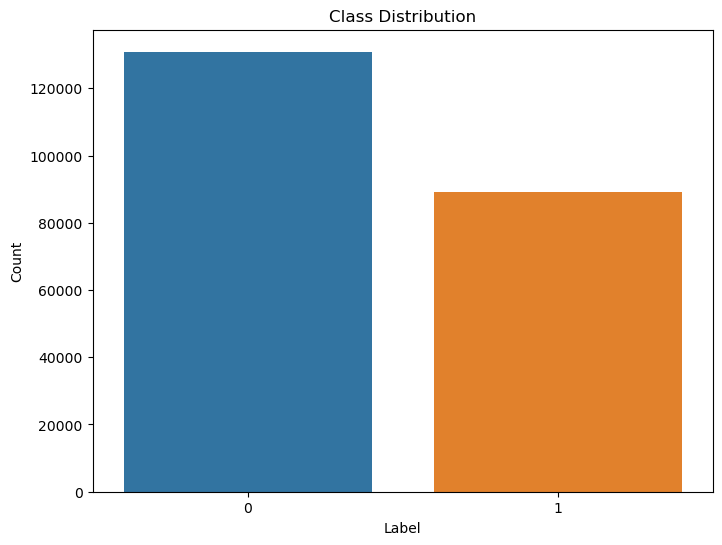

In [3]:
plt.figure(figsize=(8, 6))
sns.countplot(data=df_labels, x='label')
plt.title('Class Distribution')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

In [4]:
train = f"{DIR}/train/"
test = f"{DIR}/test"

print(f"Number of training images: {len(os.listdir(train))}")
print(f"Number of test images: {len(os.listdir(test))}")




Number of training images: 220025
Number of test images: 57458


In [5]:
img_train = os.listdir(train)
img_test = os.listdir(test)

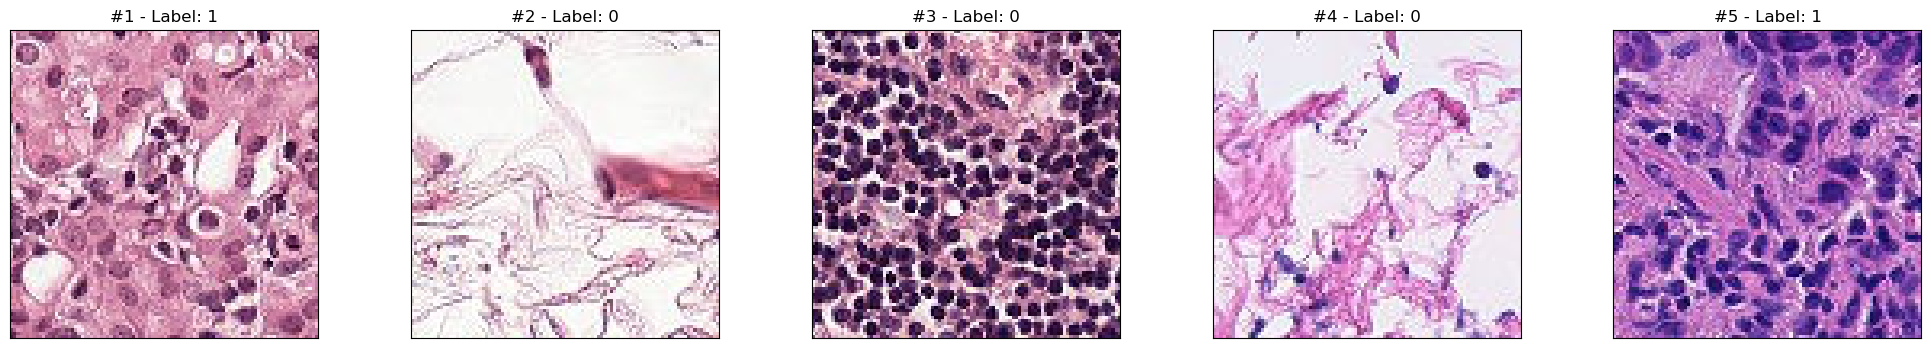

In [6]:
from PIL import Image
fig = plt.figure(figsize=(25, 4))

for i in range(5):
    ax = fig.add_subplot(1, 5, i + 1, xticks=[], yticks=[])
    im = Image.open(train + img_train[i])
    plt.imshow(im)
    label = df_labels.loc[df_labels['id'] == img_train[i].split('.')[0], 'label'].values[0]
    ax.set_title(f'#{i+1} - Label: {label}')

In [43]:
train_data, val_data = train_test_split(df_labels, test_size=0.2, random_state=42, stratify=df_labels['label'])

In [44]:


train_data = train_data.astype(str)
val_data = val_data.astype(str)
print(train_data.shape,val_data.shape)



(176020, 2) (44005, 2)


In [45]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)



In [47]:

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)



train_data['id'] += '.tif'
val_data['id'] += '.tif'



In [49]:
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_data,
    directory = train,
    x_col = 'id',
    y_col = 'label',
    target_size=(96,96),
    batch_size=32,
    class_mode='binary'
)

Found 176020 validated image filenames belonging to 2 classes.


In [50]:
val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_data,
    directory = train,
    x_col='id',
    y_col='label',
    target_size=(96,96),
    batch_size=32,
    class_mode='binary'
)

Found 44005 validated image filenames belonging to 2 classes.


In [51]:
test_data = df_samples.astype(str)
test_data['id'] += '.tif'

In [53]:
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_data,
    directory = test,
    x_col='id',
    y_col='label',
    target_size=(96,96),
    batch_size=32,
)



Found 57458 validated image filenames belonging to 1 classes.


In [59]:
from tensorflow.keras import layers
from keras.metrics import AUC
def CNN(model):
    model.add(layers.Conv2D(16, (3,3), activation='relu', input_shape=(96,96,3)))
    model.add(layers.Conv2D(16, (3,3), activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPool2D(pool_size=(3,3)))

    # Batch normalization
    model.add(layers.Conv2D(32, (3,3), activation='relu'))
    model.add(layers.Conv2D(32, (3,3), activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPool2D(pool_size=(3,3)))

    # Batch normalization
    model.add(layers.Conv2D(64, (3,3), activation='relu'))
    model.add(layers.Conv2D(64, (3,3), activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPool2D(pool_size=(3,3)))

    # Convert to 1D vector
    model.add(layers.Flatten())

    # Classification layers
    model.add(layers.Dense(64, activation='sigmoid'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(1, activation='sigmoid'))

    return model

In [61]:
RMS_model = CNN(tf.keras.Sequential())

RMS_model.compile(
    optimizer = 'RMSprop',
    loss = 'binary_crossentropy',
    metrics = [AUC()]
)

RMS_history = RMS_model.fit(
    train_generator,
    validation_data = val_generator,
    epochs = 1
)


prediction_labels_1 = RMS_model.predict(test_generator)

1186/5501 ━━━━━━━━━━━━━━━━━━━━ 30:49 429ms/step - auc_1: 0.8119 - loss: 0.5207

KeyboardInterrupt: 

In [63]:
prediction_labels_1 = RMS_model.predict(test_generator)

model_pred_df_1 = pd.DataFrame(columns=['id', 'label'])
img_test=sorted(img_test)

# Take a quick look
model_pred_df_1['id'] = [filename.split('.')[0] for filename in img_test]
model_pred_df_1['label'] = np.round(prediction_labels_1.flatten()).astype('int')
model_pred_df_1



   1/1796 ━━━━━━━━━━━━━━━━━━━━ 4:31 151ms/step

C:\Users\Admin\anaconda3\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1796/1796 ━━━━━━━━━━━━━━━━━━━━ 702s 391ms/step


,id,label
0,00006537328c33e284c973d7b39d340809f7271b,0
1,0000ec92553fda4ce39889f9226ace43cae3364e,0
2,00024a6dee61f12f7856b0fc6be20bc7a48ba3d2,0
3,000253dfaa0be9d0d100283b22284ab2f6b643f6,0
4,000270442cc15af719583a8172c87cd2bd9c7746,0
...,...,...
57453,fffdd1cbb1ac0800f65309f344dd15e9331e1c53,0
57454,fffdf4b82ba01f9cae88b9fa45be103344d9f6e3,0
57455,fffec7da56b54258038b0d382b3d55010eceb9d7,0
57456,ffff276d06a9e3fffc456f2a5a7a3fd1a2d322c6,0


In [64]:
RMS_csv = model_pred_df_1.to_csv('RMS_model_predictions.csv', index=False)